Loading the Data

In [1]:
import pandas as pd
import numpy as np

In [2]:
# Load the data
df_0 = pd.read_csv(r"C:\Users\pingk\Downloads\fadhli nitip\asik_rt4_NWIN_CLND_BLNCD_2.csv")

Selecting Regions of Interest

In [3]:
# Define the regions of interest
regions_of_interest = [
    (2996, 3016), (2943, 2963), (2912, 2932), (2843, 2863),
    (1490, 2010), (1455, 1475), (1408, 1428), (1368, 1388),
    (1225, 1245), (1150, 1170), (1106, 1126), (1088, 1108),
    (990, 920), (712, 732)
]

# Extract columns corresponding to the regions of interest
columns_to_focus = []
for start, end in regions_of_interest:
    columns_to_focus.extend([col for col in df_0.columns[4:-7] if start <= float(col) <= end])

# Create a new DataFrame with the selected regions
df_0_selected_regions = df_0[columns_to_focus]

# Combine the selected regions with the target column and other relevant columns
df_0_selected_regions = pd.concat([df_0[['thnoth_name', 'prov_char']], df_0_selected_regions], axis=1)

# Save the DataFrame for further processing
# df_0_selected_regions.to_csv('data/data file 2/data_1.csv', index=False)


FUNCTIONS

Baseline Correction

In [4]:
from scipy.signal import savgol_filter

# Function for baseline correction with dynamic window length
def baseline_correction(spectrum, default_window_length=15, polyorder=3):
    spectrum_length = len(spectrum)
    if spectrum_length < default_window_length:
        window_length = spectrum_length // 2 * 2 + 1  # Make window length odd and less than the size of the spectrum
    else:
        window_length = default_window_length
    baseline = savgol_filter(spectrum, window_length, polyorder, mode='nearest')
    corrected_spectrum = spectrum - baseline
    return corrected_spectrum

# Apply baseline correction
df_baseline_corrected_v0 = df_0_selected_regions.copy()
for col in columns_to_focus:
    df_baseline_corrected_v0[col] = baseline_correction(df_baseline_corrected_v0[col])

# Save the baseline corrected data
# df_baseline_corrected_v0.to_csv('data/data file 2/data_1_bslcrct.csv', index=False)

SavGol Smoothing

In [5]:
# Function for Savitzky-Golay smoothing
def savitzky_golay_smoothing(spectrum, default_window_length=11, polyorder=2):
    window_length = min(default_window_length, len(spectrum) // 2 * 2 + 1)  # Make window length odd and less than or equal to the size of the spectrum
    if window_length < 3:  # Ensure window length is at least 3
        window_length = 3
    return savgol_filter(spectrum, window_length, polyorder, mode='nearest')  # Set mode to 'nearest'

# Apply smoothing
df_smoothed_v0 = df_baseline_corrected_v0.copy()
for col in columns_to_focus:
    df_smoothed_v0[col] = savitzky_golay_smoothing(df_smoothed_v0[col])

# Save the smoothed data
# df_smoothed_v0.to_csv('data/data file 2/data_1_smoothed.csv', index=False)


Normalization

In [6]:
# Function for normalization (Min-Max scaling)
def min_max_normalization(spectrum):
    return (spectrum - np.min(spectrum)) / (np.max(spectrum) - np.min(spectrum))

# Apply normalization
df_normalized_v0 = df_smoothed_v0.copy()
for col in columns_to_focus:
    df_normalized_v0[col] = min_max_normalization(df_normalized_v0[col])

# Save the normalized data
# df_normalized_v0.to_csv('data/data file 2/data_1_normalized.csv', index=False)


Derivatization (np.gradient)

In [7]:
# Calculate the first derivative using np.gradient
data_spectrum = df_normalized_v0.iloc[:, 2:].values
first_derivative_np = np.gradient(data_spectrum, axis=1)

# Calculate the second derivative using np.gradient
second_derivative_np = np.gradient(first_derivative_np, axis=1)

# Convert the results back to DataFrame
data_1_der_np = pd.DataFrame(first_derivative_np, columns=df_normalized_v0.columns[2:])
data_2_der_np = pd.DataFrame(second_derivative_np, columns=df_normalized_v0.columns[2:])

# Combine the first two columns from the original dataset with the np.gradient derivatives

# Extract the first two columns
first_two_columns = df_normalized_v0.iloc[:, :2]

# Combine the first two columns with the derivatives
data_1_der_combined = pd.concat([first_two_columns, data_1_der_np], axis=1)
data_2_der_combined = pd.concat([first_two_columns, data_2_der_np], axis=1)

# Export the combined data to CSV
# data_1_der_combined.to_csv('data/data file 2/data_1_1_der.csv', index=False)
# data_2_der_combined.to_csv('data/data file 2/data_1_2_der.csv', index=False)

Derivatization (SavGol)

In [8]:
# Extract the spectrum data
data_spectrum = df_normalized_v0.iloc[:, 2:].values

# Apply Savitzky-Golay filter for the first derivative
first_derivative_savgol = savgol_filter(data_spectrum, window_length=5, polyorder=2, deriv=1, axis=1)

# Apply Savitzky-Golay filter for the second derivative
second_derivative_savgol = savgol_filter(data_spectrum, window_length=5, polyorder=2, deriv=2, axis=1)

# Convert the results back to DataFrame
data_1_der_savgol = pd.DataFrame(first_derivative_savgol, columns=df_normalized_v0.columns[2:])
data_2_der_savgol = pd.DataFrame(second_derivative_savgol, columns=df_normalized_v0.columns[2:])

# Extract the first two columns
first_two_columns = df_normalized_v0.iloc[:, :2]

# Combine the first two columns with the Savitzky-Golay derivatives
data_1_der_savgol_combined = pd.concat([first_two_columns, data_1_der_savgol], axis=1)
data_2_der_savgol_combined = pd.concat([first_two_columns, data_2_der_savgol], axis=1)

# Export the combined data to CSV
# data_1_der_savgol_combined.to_csv('data/data file 2/data_1_1_der_savgol.csv', index=False)
# data_2_der_savgol_combined.to_csv('data/data file 2/data_1_2_der_savgol.csv', index=False)

SNV

In [9]:
def snv(spectrum):
    return (spectrum - np.mean(spectrum)) / np.std(spectrum)

# Apply SNV to the selected regions
df_snv = df_0_selected_regions.copy()
for col in columns_to_focus:
    df_snv[col] = snv(df_snv[col])

# Save the SNV data
# df_snv.to_csv('data/data file 2/data_1_snv.csv', index=False)


c:\Users\pingk\OneDrive - Chulalongkorn University\Documents\mekargit\cpocluster\env\Lib\site-packages\numpy\_core\fromnumeric.py:3800: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


Random Normal Variate (RNV)

In [10]:
def rnv(spectrum):
    random_noise = np.random.normal(0, np.std(spectrum), spectrum.shape)
    return spectrum + random_noise

# Apply RNV to the selected regions
df_rnv = df_0_selected_regions.copy()
for col in columns_to_focus:
    df_rnv[col] = rnv(df_rnv[col])

# Save the RNV data
# df_rnv.to_csv('data/data file 2/data_1_rnv.csv', index=False)


Multiplicative Scatter Correction (MSC)

In [11]:
# def msc(spectrum, reference):
#     mean_spectrum = np.mean(reference, axis=0)
#     fit = np.polyfit(mean_spectrum, spectrum, 1, full=True)
#     corrected_spectrum = (spectrum - fit[0][1]) / fit[0][0]
#     return corrected_spectrum

# # Apply MSC to the selected regions
# df_msc = df_0_selected_regions.copy()
# for col in columns_to_focus:
#     df_msc[col] = msc(df_msc[col])

# # Save the MSC data
# df_msc.to_csv('data/data file 2/data_1_msc2.csv', index=False)


In [12]:
# Multiplicative Scatter Correction (MSC) function
# def msc(input_data):
#     # Mean center the data
#     mean_spectrum = np.mean(input_data, axis=0)
#     input_data_centered = input_data - mean_spectrum

#     # Perform MSC
#     reference = np.mean(input_data, axis=0)
#     msc_data = np.zeros_like(input_data)

#     for i in range(input_data.shape[0]):
#         fit = np.polyfit(reference, input_data_centered[i, :], 1, full=True)
#         msc_data[i, :] = (input_data_centered[i, :] - fit[0][1]) / fit[0][0]
    
#     return msc_data

# # Extract the spectral data from the dataframe
# spectral_data = df_0_selected_regions.iloc[:, 2:].values

# # Apply MSC
# msc_corrected_data = msc(spectral_data)

# # Create a new dataframe with the MSC corrected data
# msc_df = pd.DataFrame(msc_corrected_data, columns=df_0_selected_regions.columns[2:])
# msc_df.insert(0, 'prov_char', df_0_selected_regions['prov_char'])
# msc_df.insert(0, 'thnoth_name', df_0_selected_regions['thnoth_name'])

# # Save the MSC corrected data to a new CSV file
# msc_corrected_file_path = 'data/data file 2/data_1_msc_corrected.csv'
# msc_df.to_csv(msc_corrected_file_path, index=False)


Classification and Evaluation (40-fold)

In [13]:
# Define the target variable
target = 'thnoth_name'

# Ensure columns_to_focus are correctly identified
numeric_cols_df_0 = df_0_selected_regions.select_dtypes(include=[np.number]).columns.tolist()
columns_to_focus = numeric_cols_df_0  # Ensure columns are correctly selected

# Classification and evaluation function using 40-fold CV
def classify_and_evaluate(df, columns):
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.model_selection import cross_val_score
    from sklearn.preprocessing import LabelEncoder

    # Encode target variable
    le = LabelEncoder()
    y = le.fit_transform(df[target])

    # Define features
    X = df[columns]

    # Initialize the classifier
    model = RandomForestClassifier(n_estimators=100, random_state=42)

    # Perform cross-validation
    scores = cross_val_score(model, X, y, cv=40)

    # Print the results
    print(f'Cross-Validation Accuracy: {np.mean(scores)}')


In [14]:

# Evaluate each preprocessing method
print("Evaluation for No Preprocessing:")
classify_and_evaluate(df_0_selected_regions, columns_to_focus)

Evaluation for No Preprocessing:
Cross-Validation Accuracy: 0.9513392857142857


In [15]:
print("Evaluation for Baseline Correction:")
df_baseline_corrected_v0z = pd.read_csv('data/data file 2/data_1_bslcrct.csv')
classify_and_evaluate(df_baseline_corrected_v0z, columns_to_focus)

Evaluation for Baseline Correction:
Cross-Validation Accuracy: 0.9254464285714287


In [16]:
print("Evaluation for Smoothing:")
df_smoothed_v0z = pd.read_csv('data/data file 2/data_1_smoothed.csv')
classify_and_evaluate(df_smoothed_v0z, columns_to_focus)

Evaluation for Smoothing:
Cross-Validation Accuracy: 0.9223214285714286


In [17]:
print("Evaluation for Normalization:")
df_normalized_v0z = pd.read_csv('data/data file 2/data_1_normalized.csv')
classify_and_evaluate(df_normalized_v0z, columns_to_focus)

Evaluation for Normalization:
Cross-Validation Accuracy: 0.9223214285714286


In [18]:
print("Evaluation for 1-Derivative Spectroscopy:")
data_1_der_combined_v0z = pd.read_csv('data/data file 2/data_1_1_der.csv')
classify_and_evaluate(data_1_der_combined_v0z, columns_to_focus)

Evaluation for 1-Derivative Spectroscopy:
Cross-Validation Accuracy: 0.9089285714285715


In [19]:
print("Evaluation for 2-Derivative Spectroscopy:")
data_2_der_combined_v0z = pd.read_csv('data/data file 2/data_1_2_der.csv')
classify_and_evaluate(data_2_der_combined_v0z, columns_to_focus)

Evaluation for 2-Derivative Spectroscopy:
Cross-Validation Accuracy: 0.8959821428571431


In [20]:
print("Evaluation for 1-SG-Derivative Spectroscopy:")
data_1_der_savgol_combined_v0z = pd.read_csv('data/data file 2/data_1_1_der_savgol.csv')
classify_and_evaluate(data_1_der_savgol_combined_v0z, columns_to_focus)

Evaluation for 1-SG-Derivative Spectroscopy:
Cross-Validation Accuracy: 0.9


In [21]:
print("Evaluation for 2-SG-Derivative Spectroscopy:")
data_1_der_savgol_combined_v0z = pd.read_csv('data/data file 2/data_1_2_der_savgol.csv')
classify_and_evaluate(data_1_der_savgol_combined_v0z, columns_to_focus)

Evaluation for 2-SG-Derivative Spectroscopy:
Cross-Validation Accuracy: 0.8991071428571429


In [22]:
print("Evaluation for SNV:")
df_snv_v0z = pd.read_csv('data/data file 2/data_1_snv.csv')
classify_and_evaluate(df_snv_v0z, columns_to_focus)

print("Evaluation for RNV:")
df_rnv_v0z = pd.read_csv('data/data file 2/data_1_rnv.csv')
classify_and_evaluate(df_rnv_v0z, columns_to_focus)

print("Evaluation for MSC:")
df_msc_v0z = pd.read_csv('data/data file 2/data_1_msc.csv')
classify_and_evaluate(df_msc_v0z, columns_to_focus)

Evaluation for SNV:
Cross-Validation Accuracy: 0.9383928571428573
Evaluation for RNV:
Cross-Validation Accuracy: 0.7058035714285714
Evaluation for MSC:
Cross-Validation Accuracy: 0.9383928571428573


Classification and Evaluation (40-fold) -with extra detailed

In [23]:
# Define the target variable
target = 'thnoth_name'

# Ensure columns_to_focus are correctly identified
numeric_cols_df_0 = df_0_selected_regions.select_dtypes(include=[np.number]).columns.tolist()
columns_to_focus = numeric_cols_df_0  # Ensure columns are correctly selected

# Classification and evaluation function using 40-fold CV with detailed metrics
def classify_and_evaluate(df, columns):
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.model_selection import cross_val_score, StratifiedKFold
    from sklearn.preprocessing import LabelEncoder
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
    import numpy as np

    # Encode target variable
    le = LabelEncoder()
    y = le.fit_transform(df[target])

    # Define features
    X = df[columns]

    # Initialize the classifier
    model = RandomForestClassifier(n_estimators=100, random_state=42)

    # Initialize Stratified K-Fold Cross-Validation
    skf = StratifiedKFold(n_splits=40)

    # Arrays to store results
    accuracies = []
    precisions = []
    recalls = []
    f1_scores = []
    conf_matrices = []

    # Perform cross-validation
    for train_idx, test_idx in skf.split(X, y):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        # Train the model
        model.fit(X_train, y_train)

        # Predict and evaluate
        y_pred = model.predict(X_test)
        accuracies.append(accuracy_score(y_test, y_pred))
        precisions.append(precision_score(y_test, y_pred, average=None))
        recalls.append(recall_score(y_test, y_pred, average=None))
        f1_scores.append(f1_score(y_test, y_pred, average=None))
        conf_matrices.append(confusion_matrix(y_test, y_pred))

    # Calculate mean scores
    mean_accuracy = np.mean(accuracies)
    mean_precision = np.mean(precisions, axis=0)
    mean_recall = np.mean(recalls, axis=0)
    mean_f1 = np.mean(f1_scores, axis=0)
    mean_conf_matrix = np.mean(conf_matrices, axis=0)

    # Print the results
    print(f'Cross-Validation Accuracy: {mean_accuracy}')
    print(f'Precision per class: {mean_precision}')
    print(f'Recall per class: {mean_recall}')
    print(f'F1-score per class: {mean_f1}')


In [24]:
# Evaluate each preprocessing method
print("Evaluation for No Preprocessing:")
classify_and_evaluate(df_0_selected_regions, columns_to_focus)

print("Evaluation for Baseline Correction:")
df_baseline_corrected_v0y = pd.read_csv('data/data file 2/data_1_bslcrct.csv')
classify_and_evaluate(df_baseline_corrected_v0y, columns_to_focus)

print("Evaluation for Smoothing:")
df_smoothed_v0y = pd.read_csv('data/data file 2/data_1_smoothed.csv')
classify_and_evaluate(df_smoothed_v0y, columns_to_focus)

print("Evaluation for Normalization:")
df_normalized_v0y = pd.read_csv('data/data file 2/data_1_normalized.csv')
classify_and_evaluate(df_normalized_v0y, columns_to_focus)

print("Evaluation for 1-Derivative Spectroscopy:")
df_derivative_v0y = pd.read_csv('data/data file 2/data_1_1_der.csv')
classify_and_evaluate(df_derivative_v0y, columns_to_focus)

print("Evaluation for 2-Derivative Spectroscopy:")
data_2_der_combined_v0y = pd.read_csv('data/data file 2/data_1_2_der.csv')
classify_and_evaluate(data_2_der_combined_v0y, columns_to_focus)

print("Evaluation for 1-SG-Derivative Spectroscopy:")
data_1_der_savgol_combined_v0y = pd.read_csv('data/data file 2/data_1_1_der_savgol.csv')
classify_and_evaluate(data_1_der_savgol_combined_v0y, columns_to_focus)

print("Evaluation for 2-SG-Derivative Spectroscopy:")
data_1_der_savgol_combined_v0y = pd.read_csv('data/data file 2/data_1_2_der_savgol.csv')
classify_and_evaluate(data_1_der_savgol_combined_v0y, columns_to_focus)

Evaluation for No Preprocessing:
Cross-Validation Accuracy: 0.9513392857142857
Precision per class: [0.95375    0.97166667]
Recall per class: [0.96041667 0.93958333]
F1-score per class: [0.95015873 0.94888889]
Evaluation for Baseline Correction:
Cross-Validation Accuracy: 0.9254464285714287
Precision per class: [0.96083333 0.93011905]
Recall per class: [0.9        0.94791667]
F1-score per class: [0.91236111 0.9278842 ]
Evaluation for Smoothing:
Cross-Validation Accuracy: 0.9223214285714286
Precision per class: [0.96970238 0.90875   ]
Recall per class: [0.88958333 0.95625   ]
F1-score per class: [0.91915404 0.91922619]
Evaluation for Normalization:
Cross-Validation Accuracy: 0.9223214285714286
Precision per class: [0.96970238 0.90875   ]
Recall per class: [0.88958333 0.95625   ]
F1-score per class: [0.91915404 0.91922619]
Evaluation for 1-Derivative Spectroscopy:
Cross-Validation Accuracy: 0.9089285714285715
Precision per class: [0.96041667 0.88958333]
Recall per class: [0.86458333 0.95

In [25]:
print("Evaluation for SNV:")
df_snv_v0y = pd.read_csv('data/data file 2/data_1_snv.csv')
classify_and_evaluate(df_snv_v0y, columns_to_focus)

print("Evaluation for RNV:")
df_rnv_v0y = pd.read_csv('data/data file 2/data_1_rnv.csv')
classify_and_evaluate(df_rnv_v0y, columns_to_focus)

print("Evaluation for MSC:")
df_msc_v0y = pd.read_csv('data/data file 2/data_1_msc.csv')
classify_and_evaluate(df_msc_v0y, columns_to_focus)

Evaluation for SNV:
Cross-Validation Accuracy: 0.9383928571428573
Precision per class: [0.95291667 0.94125   ]
Recall per class: [0.92916667 0.94583333]
F1-score per class: [0.9356746  0.93821429]
Evaluation for RNV:
Cross-Validation Accuracy: 0.7058035714285714
Precision per class: [0.75958333 0.7039881 ]
Recall per class: [0.64583333 0.7625    ]
F1-score per class: [0.67210317 0.71408189]
Evaluation for MSC:
Cross-Validation Accuracy: 0.9383928571428573
Precision per class: [0.95291667 0.94125   ]
Recall per class: [0.92916667 0.94583333]
F1-score per class: [0.9356746  0.93821429]


Classification and Evaluation using LOGO-CV

In [26]:
# Classification and evaluation function using LOGO-CV with detailed metrics
def classify_and_evaluate_logo_cv_detailed(df, columns):
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.model_selection import LeaveOneGroupOut
    from sklearn.preprocessing import LabelEncoder
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
    
    # Encode target variable
    le = LabelEncoder()
    y = le.fit_transform(df[target])
    
    # Define features
    X = df[columns]
    
    # Initialize the classifier
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    
    # Initialize LOGO-CV
    logo = LeaveOneGroupOut()
    groups = df['prov_char']
    
    # Arrays to store results
    accuracies = []
    precisions = []
    recalls = []
    f1_scores = []
    all_y_test = []
    all_y_pred = []
    
    # Perform LOGO-CV
    for train_idx, test_idx in logo.split(X, y, groups=groups):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        # Train the model
        model.fit(X_train, y_train)
        
        # Predict and evaluate
        y_pred = model.predict(X_test)
        accuracies.append(accuracy_score(y_test, y_pred))
        all_y_test.extend(y_test)
        all_y_pred.extend(y_pred)
        
    # Calculate overall metrics
    mean_accuracy = np.mean(accuracies)
    precision = precision_score(all_y_test, all_y_pred, average=None)
    recall = recall_score(all_y_test, all_y_pred, average=None)
    f1 = f1_score(all_y_test, all_y_pred, average=None)
    conf_matrix = confusion_matrix(all_y_test, all_y_pred)
    
    # Print the results
    print(f'Mean Accuracy: {mean_accuracy}')
    print(f'Precision per class: {precision}')
    print(f'Recall per class: {recall}')
    print(f'F1-score per class: {f1}')
    
    # Return confusion matrix for presentation
    return conf_matrix

In [27]:
# Evaluate each preprocessing method using LOGO-CV with detailed metrics
print("LOGO-CV Evaluation for No Preprocessing:")
conf_matrix_no_preprocessing_v0x = classify_and_evaluate_logo_cv_detailed(df_0_selected_regions, columns_to_focus)

print("LOGO-CV Evaluation for Baseline Correction:")
df_baseline_corrected_v0x = pd.read_csv('data/data file 2/data_1_bslcrct.csv')
conf_matrix_baseline_v0x = classify_and_evaluate_logo_cv_detailed(df_baseline_corrected_v0x, columns_to_focus)

print("LOGO-CV Evaluation for Smoothing:")
df_smoothed_v0x = pd.read_csv('data/data file 2/data_1_smoothed.csv')
conf_matrix_smoothing_v0x = classify_and_evaluate_logo_cv_detailed(df_smoothed_v0x, columns_to_focus)

print("LOGO-CV Evaluation for Normalization:")
df_normalized_v0x = pd.read_csv('data/data file 2/data_1_normalized.csv')
conf_matrix_normalization_v0x = classify_and_evaluate_logo_cv_detailed(df_normalized_v0x, columns_to_focus)

print("LOGO-CV Evaluation for 1-Derivative Spectroscopy:")
df_1_derivative_v0x = pd.read_csv('data/data file 2/data_1_1_der.csv')
conf_matrix_1_derivative_v0x = classify_and_evaluate_logo_cv_detailed(df_1_derivative_v0x, columns_to_focus)

print("LOGO-CV Evaluation for 2-Derivative Spectroscopy:")
df_2_derivative_v0x = pd.read_csv('data/data file 2/data_1_2_der.csv')
conf_matrix_2_derivative_v0x = classify_and_evaluate_logo_cv_detailed(df_2_derivative_v0x, columns_to_focus)

print("LOGO-CV Evaluation for 1-SG-Derivative Spectroscopy:")
df_1_der_savgol_combined_v0y = pd.read_csv('data/data file 2/data_1_1_der_savgol.csv')
conf_matrix_1_sg_v0x = classify_and_evaluate_logo_cv_detailed(df_1_der_savgol_combined_v0y, columns_to_focus)

print("LOGO-CV Evaluation for 2-SG-Derivative Spectroscopy:")
df_2_der_savgol_combined_v0y = pd.read_csv('data/data file 2/data_1_2_der_savgol.csv')
conf_matrix_2_sg_v0x = classify_and_evaluate_logo_cv_detailed(df_2_der_savgol_combined_v0y, columns_to_focus)

print("LOGO-CV Evaluation for SNV:")
df_snv_v0x = pd.read_csv('data/data file 2/data_1_snv.csv')
conf_matrix_snv_v0x = classify_and_evaluate_logo_cv_detailed(df_snv_v0x, columns_to_focus)

print("LOGO-CV Evaluation for RNV:")
df_rnv_v0x = pd.read_csv('data/data file 2/data_1_rnv.csv')
conf_matrix_rnv_v0x = classify_and_evaluate_logo_cv_detailed(df_rnv_v0x, columns_to_focus)

print("LOGO-CV Evaluation for MSC:")
df_msc_v0x = pd.read_csv('data/data file 2/data_1_msc.csv')
conf_matrix_msc_v0x = classify_and_evaluate_logo_cv_detailed(df_msc_v0x, columns_to_focus)

LOGO-CV Evaluation for No Preprocessing:
Mean Accuracy: 0.7830653111580007
Precision per class: [0.85148515 0.67487685]
Recall per class: [0.56578947 0.90131579]
F1-score per class: [0.6798419  0.77183099]
LOGO-CV Evaluation for Baseline Correction:
Mean Accuracy: 0.883051700530823
Precision per class: [0.92805755 0.86060606]
Recall per class: [0.84868421 0.93421053]
F1-score per class: [0.88659794 0.89589905]
LOGO-CV Evaluation for Smoothing:
Mean Accuracy: 0.9312043622886677
Precision per class: [0.95714286 0.8902439 ]
Recall per class: [0.88157895 0.96052632]
F1-score per class: [0.91780822 0.92405063]
LOGO-CV Evaluation for Normalization:
Mean Accuracy: 0.9283765079231676
Precision per class: [0.95       0.88414634]
Recall per class: [0.875      0.95394737]
F1-score per class: [0.9109589  0.91772152]
LOGO-CV Evaluation for 1-Derivative Spectroscopy:
Mean Accuracy: 0.92745555176212
Precision per class: [0.95419847 0.84393064]
Recall per class: [0.82236842 0.96052632]
F1-score per cl

Display Confusion Matrices

In [29]:
# Function to display confusion matrix in a tabular format
def display_confusion_matrix(conf_matrix, class_labels):
    df_cm = pd.DataFrame(conf_matrix, index=class_labels, columns=class_labels)
    print(df_cm)

# Ensure LabelEncoder is defined and class labels are set
from sklearn.preprocessing import LabelEncoder

# Define the target variable and fit LabelEncoder
target = 'thnoth_name'
le = LabelEncoder()
le.fit(df_0_selected_regions[target])
class_labels = le.classes_

In [30]:
# Display confusion matrices for each preprocessing method
print("Confusion Matrix for No Preprocessing:")
display_confusion_matrix(conf_matrix_no_preprocessing_v0x, class_labels)

print("Confusion Matrix for Baseline Correction:")
display_confusion_matrix(conf_matrix_baseline_v0x, class_labels)

print("Confusion Matrix for Smoothing:")
display_confusion_matrix(conf_matrix_smoothing_v0x, class_labels)

print("Confusion Matrix for Normalization:")
display_confusion_matrix(conf_matrix_normalization_v0x, class_labels)

print("Confusion Matrix for Derivative Spectroscopy:")
display_confusion_matrix(conf_matrix_1_derivative_v0x, class_labels)

print("Confusion Matrix for Derivative Spectroscopy:")
display_confusion_matrix(conf_matrix_2_derivative_v0x, class_labels)

print("Confusion Matrix for Derivative Spectroscopy:")
display_confusion_matrix(conf_matrix_1_sg_v0x, class_labels)

print("Confusion Matrix for Derivative Spectroscopy:")
display_confusion_matrix(conf_matrix_2_sg_v0x, class_labels)

print("Confusion Matrix for SNV:")
display_confusion_matrix(conf_matrix_snv_v0x, class_labels)

print("Confusion Matrix for RNV:")
display_confusion_matrix(conf_matrix_rnv_v0x, class_labels)

print("Confusion Matrix for MSC:")
display_confusion_matrix(conf_matrix_msc_v0x, class_labels)

Confusion Matrix for No Preprocessing:
          Non-Thai  Thai
Non-Thai        86    66
Thai            15   137
Confusion Matrix for Baseline Correction:
          Non-Thai  Thai
Non-Thai       129    23
Thai            10   142
Confusion Matrix for Smoothing:
          Non-Thai  Thai
Non-Thai       134    18
Thai             6   146
Confusion Matrix for Normalization:
          Non-Thai  Thai
Non-Thai       133    19
Thai             7   145
Confusion Matrix for Derivative Spectroscopy:
          Non-Thai  Thai
Non-Thai       125    27
Thai             6   146
Confusion Matrix for Derivative Spectroscopy:
          Non-Thai  Thai
Non-Thai       122    30
Thai            11   141
Confusion Matrix for Derivative Spectroscopy:
          Non-Thai  Thai
Non-Thai       125    27
Thai             8   144
Confusion Matrix for Derivative Spectroscopy:
          Non-Thai  Thai
Non-Thai       119    33
Thai            10   142
Confusion Matrix for SNV:
          Non-Thai  Thai
Non-Thai        

In [ ]:
df_0_selected_regions = pd.read_csv('data/data file 2/data_1.csv')
df_baseline_corrected = pd.read_csv('data/data file 2/data_1_bslcrct.csv')
df_smoothed = pd.read_csv('data/data file 2/data_1_smoothed.csv')
df_normalized = pd.read_csv('data/data file 2/data_1_normalized.csv')
df_1st_derivative = pd.read_csv('data/data file 2/data_1_1_der.csv')
df_2nd_derivative = pd.read_csv('data/data file 2/data_1_2_der.csv')
df_1_der_savgol = pd.read_csv('data/data file 2/data_1_1_der_savgol.csv')
df_2_der_savgol = pd.read_csv('data/data file 2/data_1_2_der_savgol.csv')
df_snv = pd.read_csv('data/data file 2/data_1_snv.csv')
df_rnv = pd.read_csv('data/data file 2/data_1_rnv.csv')

Step-by-Step Implementation for RandomForest Classifier with Hyperparameter Tuning

Load the Smoothed Dataset

In [31]:
# Load the smoothed dataset
df_smoothed_v0w = pd.read_csv('data/data file 2/data_1_smoothed.csv')

Define the Target Variable and Features

In [32]:
# Define the target_v0w variable and feature columns
target_v0w = 'thnoth_name'
features_v0w = df_smoothed_v0w.columns.difference(['thnoth_name', 'prov_char'])
X = df_smoothed_v0w[features_v0w]
y = df_smoothed_v0w[target_v0w]
groups = df_smoothed_v0w['prov_char']

RandomForest Classification and Evaluation with LOGO-CV

In [35]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
import numpy as np

# Encode the target variable
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Initialize the RandomForest classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Initialize LOGO-CV
logo = LeaveOneGroupOut()

# Initialize lists to store results
accuracies = []
y_true_all = []
y_pred_all = []

# Perform LOGO-CV
for train_index, test_index in logo.split(X, y_encoded, groups):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y_encoded[train_index], y_encoded[test_index]
    
    # Fit the model
    rf.fit(X_train, y_train)
    
    # Predict the test samples
    y_test_pred = rf.predict(X_test)
    
    # Calculate and store test accuracies
    accuracies.append(accuracy_score(y_test, y_test_pred))
    
    # Store the prediction and actual value
    y_true_all.extend(y_test)
    y_pred_all.extend(y_test_pred)

# Calculate average accuracies
avg_accuracy = np.mean(accuracies)

print(f'Leave-One-Group-Out CV - Average Test Accuracy: {avg_accuracy}')

# Generate the classification report for the overall test predictions
report_rf_logo = classification_report(y_true_all, y_pred_all, target_names=le.classes_, output_dict=True)
print("Leave-One-Group-Out CV RandomForest Model Classification Report")
print(classification_report(y_true_all, y_pred_all, target_names=le.classes_))

# Print the confusion matrix in text format
conf_matrix = confusion_matrix(y_true_all, y_pred_all)
conf_matrix_df = pd.DataFrame(conf_matrix, index=le.classes_, columns=le.classes_)
print("Confusion Matrix:")
print(conf_matrix_df)

# Print the detailed results
for class_name, metrics in report_rf_logo.items():
    if isinstance(metrics, dict):
        print(f"Class: {class_name}")
        for metric_name, score in metrics.items():
            print(f"{metric_name}: {score}")
    else:
        print(f"{class_name}: {metrics}")
    print()


Leave-One-Group-Out CV - Average Test Accuracy: 0.9313753429283983
Leave-One-Group-Out CV RandomForest Model Classification Report
              precision    recall  f1-score   support

    Non-Thai       0.96      0.88      0.91       152
        Thai       0.88      0.96      0.92       152

    accuracy                           0.92       304
   macro avg       0.92      0.92      0.92       304
weighted avg       0.92      0.92      0.92       304

Confusion Matrix:
          Non-Thai  Thai
Non-Thai       133    19
Thai             6   146
Class: Non-Thai
precision: 0.9568345323741008
recall: 0.875
f1-score: 0.9140893470790378
support: 152.0

Class: Thai
precision: 0.8848484848484849
recall: 0.9605263157894737
f1-score: 0.9211356466876972
support: 152.0

accuracy: 0.9177631578947368

Class: macro avg
precision: 0.9208415086112929
recall: 0.9177631578947368
f1-score: 0.9176124968833674
support: 304.0

Class: weighted avg
precision: 0.9208415086112927
recall: 0.9177631578947368
f1-s

Implementing Different Classifiers on the Smoothed Dataset

In [36]:
import pandas as pd

# Define the target variable and feature columns
target_v0w = 'thnoth_name'
features_v0w = df_smoothed_v0w.columns.difference(['thnoth_name', 'prov_char'])
X = df_smoothed_v0w[features_v0w]
y = df_smoothed_v0w[target_v0w]
groups = df_smoothed_v0w['prov_char']

# Encode the target variable
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_encoded = le.fit_transform(y)


Define the Evaluation Function

In [37]:
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import numpy as np

def classify_and_evaluate_logo_cv(model, X, y, groups, class_labels):
    # Initialize LOGO-CV
    logo = LeaveOneGroupOut()

    # Initialize lists to store results
    accuracies = []
    y_true_all = []
    y_pred_all = []

    # Perform LOGO-CV
    for train_index, test_index in logo.split(X, y, groups):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Fit the model
        model.fit(X_train, y_train)

        # Predict the test samples
        y_test_pred = model.predict(X_test)

        # Calculate and store test accuracies
        accuracies.append(accuracy_score(y_test, y_test_pred))

        # Store the prediction and actual value
        y_true_all.extend(y_test)
        y_pred_all.extend(y_test_pred)

    # Calculate average accuracies
    avg_accuracy = np.mean(accuracies)

    print(f'Leave-One-Group-Out CV - Average Test Accuracy: {avg_accuracy}')

    # Generate the classification report for the overall test predictions
    report_logo = classification_report(y_true_all, y_pred_all, target_names=class_labels, output_dict=True)
    print(f"Leave-One-Group-Out CV {model.__class__.__name__} Classification Report")
    print(classification_report(y_true_all, y_pred_all, target_names=class_labels))

    # Print the confusion matrix in text format
    conf_matrix = confusion_matrix(y_true_all, y_pred_all)
    conf_matrix_df = pd.DataFrame(conf_matrix, index=class_labels, columns=class_labels)
    print("Confusion Matrix:")
    print(conf_matrix_df)

    # Print the detailed results
    for class_name, metrics in report_logo.items():
        if isinstance(metrics, dict):
            print(f"Class: {class_name}")
            for metric_name, score in metrics.items():
                print(f"{metric_name}: {score}")
        else:
            print(f"{class_name}: {metrics}")
        print()


Implement and Evaluate Each Classifier

Support Vector Machine (SVM)

In [51]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder

# Define the target variable and feature columns
target_v0w = 'thnoth_name'
features_v0w = df_smoothed_v0w.columns.difference(['thnoth_name', 'prov_char'])
X = df_smoothed_v0w[features_v0w]
y = df_smoothed_v0w[target_v0w]
groups = df_smoothed_v0w['prov_char']

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Encode the target variable
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Initialize the SVM classifier with different kernel
svm = SVC(kernel='rbf', random_state=42)

# Initialize LOGO-CV
logo = LeaveOneGroupOut()

# Initialize lists to store results
accuracies = []
y_true_all = []
y_pred_all = []

# Perform LOGO-CV
for train_index, test_index in logo.split(X_scaled, y_encoded, groups):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y_encoded[train_index], y_encoded[test_index]
    
    # Fit the model
    svm.fit(X_train, y_train)
    
    # Predict the test samples
    y_test_pred = svm.predict(X_test)
    
    # Calculate and store test accuracies
    accuracies.append(accuracy_score(y_test, y_test_pred))
    
    # Store the prediction and actual value
    y_true_all.extend(y_test)
    y_pred_all.extend(y_test_pred)

# Calculate average accuracies
avg_accuracy = np.mean(accuracies)

print(f'Leave-One-Group-Out CV - Average Test Accuracy: {avg_accuracy}')

# Generate the classification report for the overall test predictions
report_svm_logo = classification_report(y_true_all, y_pred_all, target_names=le.classes_, output_dict=True)
print("Leave-One-Group-Out CV SVM Model Classification Report")
print(classification_report(y_true_all, y_pred_all, target_names=le.classes_))

# Print the confusion matrix in text format
conf_matrix = confusion_matrix(y_true_all, y_pred_all)
conf_matrix_df = pd.DataFrame(conf_matrix, index=le.classes_, columns=le.classes_)
print("Confusion Matrix:")
print(conf_matrix_df)

# Print the detailed results
for class_name, metrics in report_svm_logo.items():
    if isinstance(metrics, dict):
        print(f"Class: {class_name}")
        for metric_name, score in metrics.items():
            print(f"{metric_name}: {score}")
    else:
        print(f"{class_name}: {metrics}")
    print()

# Calculate the overall accuracy from the classification report
overall_accuracy_report = report_svm_logo['accuracy']
print(f'Overall Accuracy from Classification Report: {overall_accuracy_report}')

# Compare the accuracies
if np.isclose(avg_accuracy, overall_accuracy_report):
    print("The average test accuracy and overall accuracy from the classification report match.")
else:
    print("There is a discrepancy between the average test accuracy and overall accuracy from the classification report.")


Leave-One-Group-Out CV - Average Test Accuracy: 0.8788749906948145
Leave-One-Group-Out CV SVM Model Classification Report
              precision    recall  f1-score   support

    Non-Thai       0.95      0.71      0.81       152
        Thai       0.77      0.96      0.85       152

    accuracy                           0.84       304
   macro avg       0.86      0.84      0.83       304
weighted avg       0.86      0.84      0.83       304

Confusion Matrix:
          Non-Thai  Thai
Non-Thai       108    44
Thai             6   146
Class: Non-Thai
precision: 0.9473684210526315
recall: 0.7105263157894737
f1-score: 0.8120300751879699
support: 152.0

Class: Thai
precision: 0.7684210526315789
recall: 0.9605263157894737
f1-score: 0.8538011695906432
support: 152.0

accuracy: 0.8355263157894737

Class: macro avg
precision: 0.8578947368421053
recall: 0.8355263157894737
f1-score: 0.8329156223893066
support: 304.0

Class: weighted avg
precision: 0.8578947368421053
recall: 0.8355263157894737


In [82]:
# Define the target variable and feature columns
target_v0w = 'thnoth_name'
features_v0w = df_smoothed_v0w.columns.difference(['thnoth_name', 'prov_char'])
X = df_smoothed_v0w[features_v0w]
y = df_smoothed_v0w[target_v0w]
groups = df_smoothed_v0w['prov_char']

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Encode the target variable
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Initialize the SVM classifier
svm = SVC(kernel='rbf', random_state=42)

# Initialize LOGO-CV
logo = LeaveOneGroupOut()

# Initialize lists to store results
y_true_svm2_all = []
y_pred_svm2_all = []

# Perform LOGO-CV
for train_index, test_index in logo.split(X_scaled, y_encoded, groups):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y_encoded[train_index], y_encoded[test_index]
    
    # Fit the model
    svm.fit(X_train, y_train)
    
    # Predict the test samples
    y_test_pred = svm.predict(X_test)
    
    # Store the prediction and actual value
    y_true_svm2_all.extend(y_test)
    y_pred_svm2_all.extend(y_test_pred)

# Calculate the overall accuracy
overall_accuracy = accuracy_score(y_true_svm2_all, y_pred_svm2_all)

print(f'Leave-One-Group-Out CV - Overall Test Accuracy: {overall_accuracy}')

# Generate the classification report for the overall test predictions
report_svm1_logo = classification_report(y_true_svm2_all, y_pred_svm2_all, target_names=le.classes_, output_dict=True)
print("Leave-One-Group-Out CV SVM Model Classification Report")
print(classification_report(y_true_svm2_all, y_pred_svm2_all, target_names=le.classes_))

# Print the confusion matrix in text format
conf_matrix = confusion_matrix(y_true_svm2_all, y_pred_svm2_all)
conf_matrix_df = pd.DataFrame(conf_matrix, index=le.classes_, columns=le.classes_)
print("Confusion Matrix:")
print(conf_matrix_df)

# Print the detailed results
for class_name, metrics in report_svm1_logo.items():
    if isinstance(metrics, dict):
        print(f"Class: {class_name}")
        for metric_name, score in metrics.items():
            print(f"{metric_name}: {score}")
    else:
        print(f"{class_name}: {metrics}")
    print()


Leave-One-Group-Out CV - Overall Test Accuracy: 0.8355263157894737
Leave-One-Group-Out CV SVM Model Classification Report
              precision    recall  f1-score   support

    Non-Thai       0.95      0.71      0.81       152
        Thai       0.77      0.96      0.85       152

    accuracy                           0.84       304
   macro avg       0.86      0.84      0.83       304
weighted avg       0.86      0.84      0.83       304

Confusion Matrix:
          Non-Thai  Thai
Non-Thai       108    44
Thai             6   146
Class: Non-Thai
precision: 0.9473684210526315
recall: 0.7105263157894737
f1-score: 0.8120300751879699
support: 152.0

Class: Thai
precision: 0.7684210526315789
recall: 0.9605263157894737
f1-score: 0.8538011695906432
support: 152.0

accuracy: 0.8355263157894737

Class: macro avg
precision: 0.8578947368421053
recall: 0.8355263157894737
f1-score: 0.8329156223893066
support: 304.0

Class: weighted avg
precision: 0.8578947368421053
recall: 0.8355263157894737


Random Forest (RF) classifier

In [76]:
# Encode the target variable
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Initialize the Random Forest classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Initialize LOGO-CV
logo = LeaveOneGroupOut()

# Initialize lists to store results
y_true_rf2_all = []
y_pred_rf2_all = []

# Perform LOGO-CV
for train_index, test_index in logo.split(X, y_encoded, groups):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y_encoded[train_index], y_encoded[test_index]
    
    # Fit the model
    rf.fit(X_train, y_train)
    
    # Predict the test samples
    y_test_pred = rf.predict(X_test)
    
    # Store the prediction and actual value
    y_true_rf2_all.extend(y_test)
    y_pred_rf2_all.extend(y_test_pred)

# Calculate the overall accuracy
overall_accuracy = accuracy_score(y_true_rf2_all, y_pred_rf2_all)

print(f'Leave-One-Group-Out CV - Overall Test Accuracy: {overall_accuracy}')

# Generate the classification report for the overall test predictions
report_rf_logo = classification_report(y_true_rf2_all, y_pred_rf2_all, target_names=le.classes_, output_dict=True)
print("Leave-One-Group-Out CV Random Forest Model Classification Report")
print(classification_report(y_true_rf2_all, y_pred_rf2_all, target_names=le.classes_))

# Print the confusion matrix in text format
conf_matrix = confusion_matrix(y_true_rf2_all, y_pred_rf2_all)
conf_matrix_df = pd.DataFrame(conf_matrix, index=le.classes_, columns=le.classes_)
print("Confusion Matrix:")
print(conf_matrix_df)

# Print the detailed results
for class_name, metrics in report_rf_logo.items():
    if isinstance(metrics, dict):
        print(f"Class: {class_name}")
        for metric_name, score in metrics.items():
            print(f"{metric_name}: {score}")
    else:
        print(f"{class_name}: {metrics}")
    print()


Leave-One-Group-Out CV - Overall Test Accuracy: 0.9177631578947368
Leave-One-Group-Out CV Random Forest Model Classification Report
              precision    recall  f1-score   support

    Non-Thai       0.96      0.88      0.91       152
        Thai       0.88      0.96      0.92       152

    accuracy                           0.92       304
   macro avg       0.92      0.92      0.92       304
weighted avg       0.92      0.92      0.92       304

Confusion Matrix:
          Non-Thai  Thai
Non-Thai       133    19
Thai             6   146
Class: Non-Thai
precision: 0.9568345323741008
recall: 0.875
f1-score: 0.9140893470790378
support: 152.0

Class: Thai
precision: 0.8848484848484849
recall: 0.9605263157894737
f1-score: 0.9211356466876972
support: 152.0

accuracy: 0.9177631578947368

Class: macro avg
precision: 0.9208415086112929
recall: 0.9177631578947368
f1-score: 0.9176124968833674
support: 304.0

Class: weighted avg
precision: 0.9208415086112927
recall: 0.9177631578947368
f1-

Extra Trees (ET) classifier

In [72]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder

# Load the smoothed dataset
df_smoothed_v0w = pd.read_csv('data/data file 2/data_1_smoothed.csv')

# Define the target variable and feature columns
target_v0u = 'thnoth_name'
features_v0u = df_smoothed_v0w.columns.difference(['thnoth_name', 'prov_char'])
X = df_smoothed_v0w[features_v0u]
y = df_smoothed_v0w[target_v0u]
groups = df_smoothed_v0w['prov_char']

# Encode the target variable
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Initialize the Extra Trees classifier
et = ExtraTreesClassifier(n_estimators=100, random_state=42)

# Initialize LOGO-CV
logo = LeaveOneGroupOut()

# Initialize lists to store results
y_true_et_all = []
y_pred_et_all = []

# Perform LOGO-CV
for train_index, test_index in logo.split(X, y_encoded, groups):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y_encoded[train_index], y_encoded[test_index]
    
    # Fit the model
    et.fit(X_train, y_train)
    
    # Predict the test samples
    y_test_pred = et.predict(X_test)
    
    # Store the prediction and actual value
    y_true_et_all.extend(y_test)
    y_pred_et_all.extend(y_test_pred)

# Calculate the overall accuracy
overall_accuracy = accuracy_score(y_true_et_all, y_pred_et_all)

print(f'Leave-One-Group-Out CV - Overall Test Accuracy: {overall_accuracy}')

# Generate the classification report for the overall test predictions
report_et_logo = classification_report(y_true_et_all, y_pred_et_all, target_names=le.classes_, output_dict=True)
print("Leave-One-Group-Out CV Extra Trees Model Classification Report")
print(classification_report(y_true_et_all, y_pred_et_all, target_names=le.classes_))

# Print the confusion matrix in text format
conf_matrix = confusion_matrix(y_true_et_all, y_pred_et_all)
conf_matrix_df = pd.DataFrame(conf_matrix, index=le.classes_, columns=le.classes_)
print("Confusion Matrix:")
print(conf_matrix_df)

# Print the detailed results
for class_name, metrics in report_et_logo.items():
    if isinstance(metrics, dict):
        print(f"Class: {class_name}")
        for metric_name, score in metrics.items():
            print(f"{metric_name}: {score}")
    else:
        print(f"{class_name}: {metrics}")
    print()


Leave-One-Group-Out CV - Overall Test Accuracy: 0.9111842105263158
Leave-One-Group-Out CV Extra Trees Model Classification Report
              precision    recall  f1-score   support

    Non-Thai       0.95      0.87      0.91       152
        Thai       0.88      0.95      0.91       152

    accuracy                           0.91       304
   macro avg       0.91      0.91      0.91       304
weighted avg       0.91      0.91      0.91       304

Confusion Matrix:
          Non-Thai  Thai
Non-Thai       132    20
Thai             7   145
Class: Non-Thai
precision: 0.9496402877697842
recall: 0.868421052631579
f1-score: 0.9072164948453608
support: 152.0

Class: Thai
precision: 0.8787878787878788
recall: 0.9539473684210527
f1-score: 0.9148264984227129
support: 152.0

accuracy: 0.9111842105263158

Class: macro avg
precision: 0.9142140832788315
recall: 0.9111842105263158
f1-score: 0.9110214966340369
support: 304.0

Class: weighted avg
precision: 0.9142140832788314
recall: 0.9111842105

k-Nearest Neighbors (kNN)

In [73]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder

# Define the target variable and feature columns
target_v0u = 'thnoth_name'
features_v0u = df_smoothed_v0w.columns.difference(['thnoth_name', 'prov_char'])
X = df_smoothed_v0w[features_v0u]
y = df_smoothed_v0w[target_v0u]
groups = df_smoothed_v0w['prov_char']

# Encode the target variable
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Initialize the kNN classifier
knn = KNeighborsClassifier(n_neighbors=5)

# Initialize LOGO-CV
logo = LeaveOneGroupOut()

# Initialize lists to store results
y_true_knn_all = []
y_pred_knn_all = []

# Perform LOGO-CV
for train_index, test_index in logo.split(X, y_encoded, groups):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y_encoded[train_index], y_encoded[test_index]
    
    # Fit the model
    knn.fit(X_train, y_train)
    
    # Predict the test samples
    y_test_pred = knn.predict(X_test)
    
    # Store the prediction and actual value
    y_true_knn_all.extend(y_test)
    y_pred_knn_all.extend(y_test_pred)

# Calculate the overall accuracy
overall_accuracy = accuracy_score(y_true_knn_all, y_pred_knn_all)

print(f'Leave-One-Group-Out CV - Overall Test Accuracy: {overall_accuracy}')

# Generate the classification report for the overall test predictions
report_knn_logo = classification_report(y_true_knn_all, y_pred_knn_all, target_names=le.classes_, output_dict=True)
print("Leave-One-Group-Out CV kNN Model Classification Report")
print(classification_report(y_true_knn_all, y_pred_knn_all, target_names=le.classes_))

# Print the confusion matrix in text format
conf_matrix = confusion_matrix(y_true_knn_all, y_pred_knn_all)
conf_matrix_df = pd.DataFrame(conf_matrix, index=le.classes_, columns=le.classes_)
print("Confusion Matrix:")
print(conf_matrix_df)

# Print the detailed results
for class_name, metrics in report_knn_logo.items():
    if isinstance(metrics, dict):
        print(f"Class: {class_name}")
        for metric_name, score in metrics.items():
            print(f"{metric_name}: {score}")
    else:
        print(f"{class_name}: {metrics}")
    print()


Leave-One-Group-Out CV - Overall Test Accuracy: 0.9013157894736842
Leave-One-Group-Out CV kNN Model Classification Report
              precision    recall  f1-score   support

    Non-Thai       0.98      0.82      0.89       152
        Thai       0.84      0.99      0.91       152

    accuracy                           0.90       304
   macro avg       0.91      0.90      0.90       304
weighted avg       0.91      0.90      0.90       304

Confusion Matrix:
          Non-Thai  Thai
Non-Thai       124    28
Thai             2   150
Class: Non-Thai
precision: 0.9841269841269841
recall: 0.8157894736842105
f1-score: 0.8920863309352518
support: 152.0

Class: Thai
precision: 0.8426966292134831
recall: 0.9868421052631579
f1-score: 0.9090909090909091
support: 152.0

accuracy: 0.9013157894736842

Class: macro avg
precision: 0.9134118066702336
recall: 0.9013157894736842
f1-score: 0.9005886200130804
support: 304.0

Class: weighted avg
precision: 0.9134118066702336
recall: 0.9013157894736842


Gradient Boosting Classifier (GBC)

In [62]:
from sklearn.ensemble import GradientBoostingClassifier

# Initialize the Gradient Boosting Classifier
model_gbc = GradientBoostingClassifier(random_state=42)

# Initialize Leave-One-Group-Out Cross-Validation
logo = LeaveOneGroupOut()

# Initialize lists to store results
accuracies_gbc = []
y_true_all_gbc = []
y_pred_all_gbc = []

# Apply LOGO-CV
for train_index, test_index in logo.split(X, y_encoded, groups):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y_encoded[train_index], y_encoded[test_index]
    
    # Fit the model
    model_gbc.fit(X_train, y_train)
    
    # Predict the test samples
    y_test_pred = model_gbc.predict(X_test)
    
    # Calculate and store the accuracy
    accuracies_gbc.append(accuracy_score(y_test, y_test_pred))
    
    # Store the prediction and actual values
    y_true_all_gbc.extend(y_test)
    y_pred_all_gbc.extend(y_test_pred)

# Calculate the overall accuracy
overall_accuracy_gbc = accuracy_score(y_true_all_gbc, y_pred_all_gbc)

print(f'Leave-One-Group-Out CV - Average Test Accuracy: {overall_accuracy_gbc}')
print("Leave-One-Group-Out CV GBC Model Classification Report")
report_gbc_logo = classification_report(y_true_all_gbc, y_pred_all_gbc, target_names=le.classes_, output_dict=True)
print(classification_report(y_true_all_gbc, y_pred_all_gbc, target_names=le.classes_))

# Generate and display the confusion matrix
cm_logo_gbc = confusion_matrix(y_true_all_gbc, y_pred_all_gbc)
df_cm_gbc = pd.DataFrame(cm_logo_gbc, index=le.classes_, columns=le.classes_)
print("Confusion Matrix:")
print(df_cm_gbc)

# Display the detailed results
for class_name, metrics in report_gbc_logo.items():
    if isinstance(metrics, dict):
        print(f"Class: {class_name}")
        for metric_name, score in metrics.items():
            print(f"{metric_name}: {score}")
    else:
        print(f"{class_name}: {metrics}")
    print()


Leave-One-Group-Out CV - Average Test Accuracy: 0.9177631578947368
Leave-One-Group-Out CV GBC Model Classification Report
              precision    recall  f1-score   support

    Non-Thai       0.94      0.89      0.92       152
        Thai       0.89      0.95      0.92       152

    accuracy                           0.92       304
   macro avg       0.92      0.92      0.92       304
weighted avg       0.92      0.92      0.92       304

Confusion Matrix:
          Non-Thai  Thai
Non-Thai       135    17
Thai             8   144
Class: Non-Thai
precision: 0.9440559440559441
recall: 0.8881578947368421
f1-score: 0.9152542372881356
support: 152.0

Class: Thai
precision: 0.8944099378881988
recall: 0.9473684210526315
f1-score: 0.9201277955271565
support: 152.0

accuracy: 0.9177631578947368

Class: macro avg
precision: 0.9192329409720714
recall: 0.9177631578947368
f1-score: 0.917691016407646
support: 304.0

Class: weighted avg
precision: 0.9192329409720714
recall: 0.9177631578947368
f

LightGBM (LGBM) classifier 

In [63]:
import lightgbm as lgb
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Initialize the LightGBM Classifier
model_lgbm = lgb.LGBMClassifier(random_state=42)

# Initialize Leave-One-Group-Out Cross-Validation
logo = LeaveOneGroupOut()

# Initialize lists to store results
accuracies_lgbm = []
y_true_all_lgbm = []
y_pred_all_lgbm = []

# Apply LOGO-CV
for train_index, test_index in logo.split(X, y_encoded, groups):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y_encoded[train_index], y_encoded[test_index]
    
    # Fit the model
    model_lgbm.fit(X_train, y_train)
    
    # Predict the test samples
    y_test_pred = model_lgbm.predict(X_test)
    
    # Calculate and store the accuracy
    accuracies_lgbm.append(accuracy_score(y_test, y_test_pred))
    
    # Store the prediction and actual values
    y_true_all_lgbm.extend(y_test)
    y_pred_all_lgbm.extend(y_test_pred)

# Calculate the overall accuracy
overall_accuracy_lgbm = accuracy_score(y_true_all_lgbm, y_pred_all_lgbm)

print(f'Leave-One-Group-Out CV - Average Test Accuracy: {overall_accuracy_lgbm}')
print("Leave-One-Group-Out CV LGBM Model Classification Report")
report_lgbm_logo = classification_report(y_true_all_lgbm, y_pred_all_lgbm, target_names=le.classes_, output_dict=True)
print(classification_report(y_true_all_lgbm, y_pred_all_lgbm, target_names=le.classes_))

# Generate and display the confusion matrix
cm_logo_lgbm = confusion_matrix(y_true_all_lgbm, y_pred_all_lgbm)
df_cm_lgbm = pd.DataFrame(cm_logo_lgbm, index=le.classes_, columns=le.classes_)
print("Confusion Matrix:")
print(df_cm_lgbm)

# Display the detailed results
for class_name, metrics in report_lgbm_logo.items():
    if isinstance(metrics, dict):
        print(f"Class: {class_name}")
        for metric_name, score in metrics.items():
            print(f"{metric_name}: {score}")
    else:
        print(f"{class_name}: {metrics}")
    print()


[LightGBM] [Info] Number of positive: 152, number of negative: 134
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012244 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 151148
[LightGBM] [Info] Number of data points in the train set: 286, number of used features: 1576
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.531469 -> initscore=0.126041
[LightGBM] [Info] Start training from score 0.126041
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

Linear Discriminant Analysis (LDA) classifier

In [64]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Initialize the LDA Classifier
model_lda = LinearDiscriminantAnalysis()

# Initialize Leave-One-Group-Out Cross-Validation
logo = LeaveOneGroupOut()

# Initialize lists to store results
accuracies_lda = []
y_true_all_lda = []
y_pred_all_lda = []

# Apply LOGO-CV
for train_index, test_index in logo.split(X, y_encoded, groups):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y_encoded[train_index], y_encoded[test_index]
    
    # Fit the model
    model_lda.fit(X_train, y_train)
    
    # Predict the test samples
    y_test_pred = model_lda.predict(X_test)
    
    # Calculate and store the accuracy
    accuracies_lda.append(accuracy_score(y_test, y_test_pred))
    
    # Store the prediction and actual values
    y_true_all_lda.extend(y_test)
    y_pred_all_lda.extend(y_test_pred)

# Calculate the overall accuracy
overall_accuracy_lda = accuracy_score(y_true_all_lda, y_pred_all_lda)

print(f'Leave-One-Group-Out CV - Average Test Accuracy: {overall_accuracy_lda}')
print("Leave-One-Group-Out CV LDA Model Classification Report")
report_lda_logo = classification_report(y_true_all_lda, y_pred_all_lda, target_names=le.classes_, output_dict=True)
print(classification_report(y_true_all_lda, y_pred_all_lda, target_names=le.classes_))

# Generate and display the confusion matrix
cm_logo_lda = confusion_matrix(y_true_all_lda, y_pred_all_lda)
df_cm_lda = pd.DataFrame(cm_logo_lda, index=le.classes_, columns=le.classes_)
print("Confusion Matrix:")
print(df_cm_lda)

# Display the detailed results
for class_name, metrics in report_lda_logo.items():
    if isinstance(metrics, dict):
        print(f"Class: {class_name}")
        for metric_name, score in metrics.items():
            print(f"{metric_name}: {score}")
    else:
        print(f"{class_name}: {metrics}")
    print()


Leave-One-Group-Out CV - Average Test Accuracy: 0.3157894736842105
Leave-One-Group-Out CV LDA Model Classification Report
              precision    recall  f1-score   support

    Non-Thai       0.31      0.29      0.30       152
        Thai       0.33      0.34      0.33       152

    accuracy                           0.32       304
   macro avg       0.32      0.32      0.32       304
weighted avg       0.32      0.32      0.32       304

Confusion Matrix:
          Non-Thai  Thai
Non-Thai        44   108
Thai           100    52
Class: Non-Thai
precision: 0.3055555555555556
recall: 0.2894736842105263
f1-score: 0.2972972972972973
support: 152.0

Class: Thai
precision: 0.325
recall: 0.34210526315789475
f1-score: 0.3333333333333333
support: 152.0

accuracy: 0.3157894736842105

Class: macro avg
precision: 0.31527777777777777
recall: 0.3157894736842105
f1-score: 0.3153153153153153
support: 304.0

Class: weighted avg
precision: 0.31527777777777777
recall: 0.3157894736842105
f1-score: 

In [74]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Initialize the LDA Classifier
model_lda = LinearDiscriminantAnalysis()

# Initialize Leave-One-Group-Out Cross-Validation
logo = LeaveOneGroupOut()

# Initialize lists to store results
accuracies_lda = []
y_true_all_ldar = []
y_pred_all_ldar = []

# Apply LOGO-CV
for train_index, test_index in logo.split(X, y_encoded, groups):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y_encoded[train_index], y_encoded[test_index]
    
    # Fit the model
    model_lda.fit(X_train, y_train)
    
    # Predict the test samples
    y_test_pred = model_lda.predict(X_test)
    
    # Calculate and store the accuracy
    accuracies_lda.append(accuracy_score(y_test, y_test_pred))
    
    # Store the prediction and actual values
    y_true_all_ldar.extend(y_test)
    y_pred_all_ldar.extend(y_test_pred)

# Reverse the predicted classes
y_pred_all_ldar_reversed = [1 - y for y in y_pred_all_ldar]

# Calculate the overall accuracy for the reversed predictions
overall_accuracy_lda_reversed = accuracy_score(y_true_all_ldar, y_pred_all_ldar_reversed)

print(f'Leave-One-Group-Out CV - Average Test Accuracy (Reversed Classes): {overall_accuracy_lda_reversed}')
print("Leave-One-Group-Out CV LDA Model Classification Report (Reversed Classes)")
report_lda_logo_reversed = classification_report(y_true_all_ldar, y_pred_all_ldar_reversed, target_names=le.classes_, output_dict=True)
print(classification_report(y_true_all_ldar, y_pred_all_ldar_reversed, target_names=le.classes_))

# Generate and display the confusion matrix for the reversed predictions
cm_logo_lda_reversed = confusion_matrix(y_true_all_ldar, y_pred_all_ldar_reversed)
df_cm_lda_reversed = pd.DataFrame(cm_logo_lda_reversed, index=le.classes_, columns=le.classes_)
print("Confusion Matrix (Reversed Classes):")
print(df_cm_lda_reversed)

# Display the detailed results for the reversed predictions
for class_name, metrics in report_lda_logo_reversed.items():
    if isinstance(metrics, dict):
        print(f"Class: {class_name}")
        for metric_name, score in metrics.items():
            print(f"{metric_name}: {score}")
    else:
        print(f"{class_name}: {metrics}")
    print()


Leave-One-Group-Out CV - Average Test Accuracy (Reversed Classes): 0.6842105263157895
Leave-One-Group-Out CV LDA Model Classification Report (Reversed Classes)
              precision    recall  f1-score   support

    Non-Thai       0.68      0.71      0.69       152
        Thai       0.69      0.66      0.68       152

    accuracy                           0.68       304
   macro avg       0.68      0.68      0.68       304
weighted avg       0.68      0.68      0.68       304

Confusion Matrix (Reversed Classes):
          Non-Thai  Thai
Non-Thai       108    44
Thai            52   100
Class: Non-Thai
precision: 0.675
recall: 0.7105263157894737
f1-score: 0.6923076923076923
support: 152.0

Class: Thai
precision: 0.6944444444444444
recall: 0.6578947368421053
f1-score: 0.6756756756756757
support: 152.0

accuracy: 0.6842105263157895

Class: macro avg
precision: 0.6847222222222222
recall: 0.6842105263157895
f1-score: 0.683991683991684
support: 304.0

Class: weighted avg
precision: 0.6

Logistic Regression classifier

In [77]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

# Initialize Logistic Regression model with a different solver
logreg_model = LogisticRegression(random_state=42, max_iter=10000, solver='liblinear')

# Standardize the data (mean=0, variance=1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Initialize Leave-One-Group-Out Cross-Validation
logo = LeaveOneGroupOut()

# Initialize lists to store results
test_accuracies_logreg = []
y_true_all_logreg = []
y_pred_all_logreg = []

# Apply LOGO-CV
for train_index, test_index in logo.split(X_scaled, y, groups):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Fit the model
    logreg_model.fit(X_train, y_train)
    
    # Predict the test samples
    y_test_pred = logreg_model.predict(X_test)
    
    # Calculate and store test accuracies
    test_accuracies_logreg.append(accuracy_score(y_test, y_test_pred))
    
    # Store the prediction and actual value
    y_true_all_logreg.extend(y_test)
    y_pred_all_logreg.extend(y_test_pred)

# Flip the predictions
y_pred_lg_flipped = ['Non-Thai' if pred == 'Thai' else 'Thai' for pred in y_pred_all_logreg]

# Generate the classification report for the flipped predictions
report_logreg_flipped = classification_report(y_true_all_logreg, y_pred_lg_flipped, target_names=le.classes_, output_dict=True)
print("Leave-One-Group-Out CV Logistic Regression Model (Flipped) Classification Report")
print(classification_report(y_true_all_logreg, y_pred_lg_flipped, target_names=le.classes_))

# Generate and display the confusion matrix for the flipped predictions
cm_logreg_flipped = confusion_matrix(y_true_all_logreg, y_pred_lg_flipped)
df_cm_logreg_flipped = pd.DataFrame(cm_logreg_flipped, index=le.classes_, columns=le.classes_)
print("Confusion Matrix (Flipped):")
print(df_cm_logreg_flipped)

# Display the detailed results for the flipped predictions
for class_name, metrics in report_logreg_flipped.items():
    if isinstance(metrics, dict):
        print(f"Class: {class_name}")
        for metric_name, score in metrics.items():
            print(f"{metric_name}: {score}")
    else:
        print(f"{class_name}: {metrics}")
    print()


Leave-One-Group-Out CV Logistic Regression Model (Flipped) Classification Report
              precision    recall  f1-score   support

    Non-Thai       0.96      0.95      0.95       152
        Thai       0.95      0.96      0.95       152

    accuracy                           0.95       304
   macro avg       0.95      0.95      0.95       304
weighted avg       0.95      0.95      0.95       304

Confusion Matrix (Flipped):
          Non-Thai  Thai
Non-Thai       144     8
Thai             6   146
Class: Non-Thai
precision: 0.96
recall: 0.9473684210526315
f1-score: 0.9536423841059603
support: 152.0

Class: Thai
precision: 0.948051948051948
recall: 0.9605263157894737
f1-score: 0.954248366013072
support: 152.0

accuracy: 0.9539473684210527

Class: macro avg
precision: 0.954025974025974
recall: 0.9539473684210527
f1-score: 0.9539453750595162
support: 304.0

Class: weighted avg
precision: 0.9540259740259739
recall: 0.9539473684210527
f1-score: 0.9539453750595159
support: 304.0



ConfusionMatrixDisplay

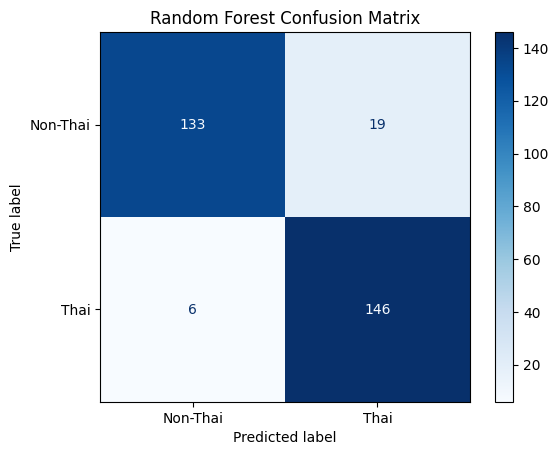

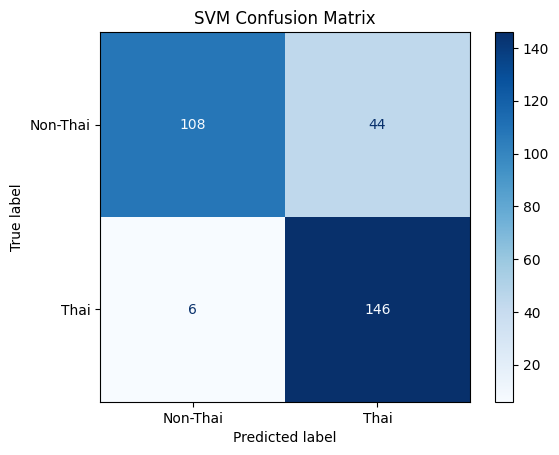

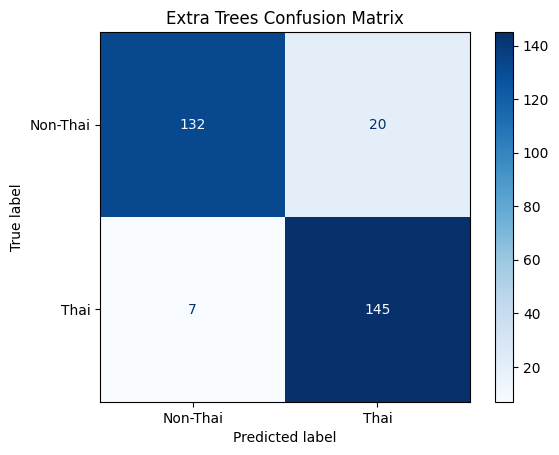

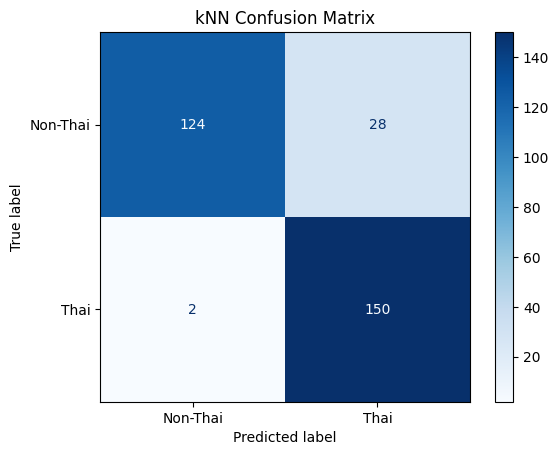

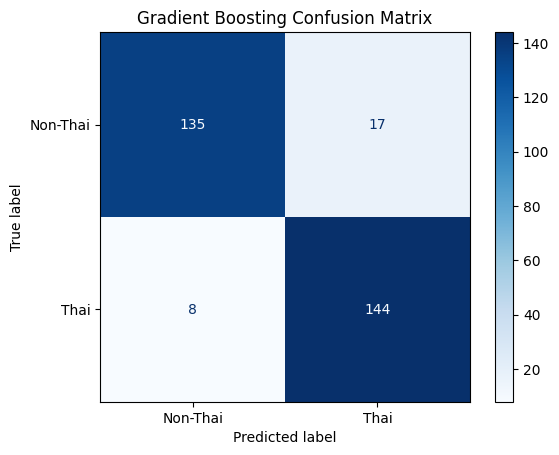

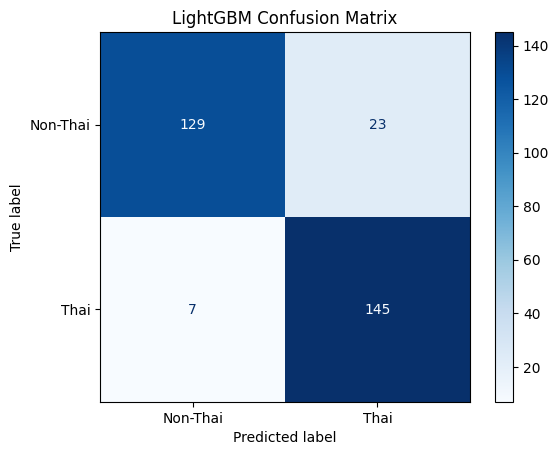

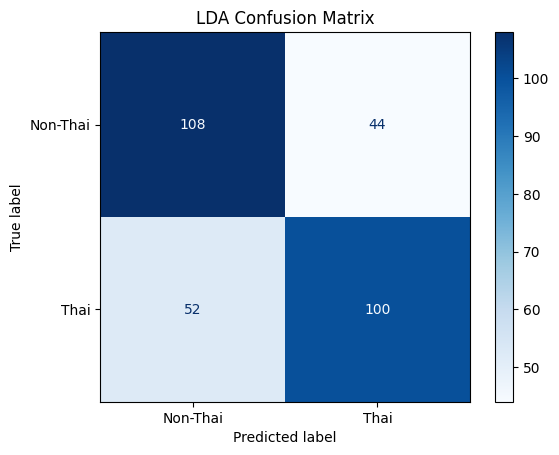

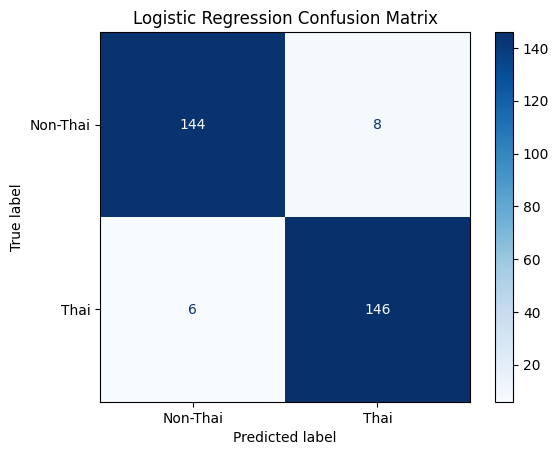

In [79]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Assuming you have the true labels and predictions for each classifier stored in the following variables:
# y_true_rf, y_pred_rf
# y_true_svm, y_pred_svm
# y_true_et, y_pred_et
# y_true_knn, y_pred_knn
# y_true_gbc, y_pred_gbc
# y_true_lgbm, y_pred_lgbm
# y_true_lda, y_pred_lda
# y_true_logreg, y_pred_logreg

# y_true_rf2_all, y_pred_rf2_all
# y_true_svm2_all,  y_pred_svm2_all
# y_true_et_all, y_pred_et_all
# y_true_knn_all, y_pred_knn_all
# y_true_all_gbc, y_pred_all_gbc
# y_true_all_lgbm, y_pred_all_lgbm
# y_true_all_ldar, y_pred_all_ldar_reversed
# y_true_all_logreg, y_pred_lg_flipped

# Define the class labels
class_labels = le.classes_

# Function to display confusion matrix
def display_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title)
    plt.show()

# Display confusion matrices for each classifier
display_confusion_matrix(y_true_rf2_all, y_pred_rf2_all, 'Random Forest Confusion Matrix')
display_confusion_matrix(y_true_svm2_all,  y_pred_svm2_all, 'SVM Confusion Matrix')
display_confusion_matrix(y_true_et_all, y_pred_et_all, 'Extra Trees Confusion Matrix')
display_confusion_matrix(y_true_knn_all, y_pred_knn_all, 'kNN Confusion Matrix')
display_confusion_matrix(y_true_all_gbc, y_pred_all_gbc, 'Gradient Boosting Confusion Matrix')
display_confusion_matrix(y_true_all_lgbm, y_pred_all_lgbm, 'LightGBM Confusion Matrix')
display_confusion_matrix(y_true_all_ldar, y_pred_all_ldar_reversed, 'LDA Confusion Matrix')
display_confusion_matrix(y_true_all_logreg, y_pred_lg_flipped, 'Logistic Regression Confusion Matrix')


Displaying Confusion Matrices as Text Tables

In [81]:
# Function to display confusion matrix as a text table
def display_confusion_matrix_text(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    df_cm = pd.DataFrame(cm, index=class_labels, columns=class_labels)
    print(title)
    print(df_cm)
    print()

# Display confusion matrices for each classifier as text tables
display_confusion_matrix_text(y_true_rf2_all, y_pred_rf2_all, 'Random Forest Confusion Matrix')
display_confusion_matrix_text(y_true_svm2_all,  y_pred_svm2_all, 'SVM Confusion Matrix')
display_confusion_matrix_text(y_true_et_all, y_pred_et_all, 'Extra Trees Confusion Matrix')
display_confusion_matrix_text(y_true_knn_all, y_pred_knn_all, 'kNN Confusion Matrix')
display_confusion_matrix_text(y_true_all_gbc, y_pred_all_gbc, 'Gradient Boosting Confusion Matrix')
display_confusion_matrix_text(y_true_all_lgbm, y_pred_all_lgbm, 'LightGBM Confusion Matrix')
display_confusion_matrix_text(y_true_all_ldar, y_pred_all_ldar_reversed, 'LDA Confusion Matrix')
display_confusion_matrix_text(y_true_all_logreg, y_pred_lg_flipped, 'Logistic Regression Confusion Matrix')


Random Forest Confusion Matrix
          Non-Thai  Thai
Non-Thai       133    19
Thai             6   146

SVM Confusion Matrix
          Non-Thai  Thai
Non-Thai       108    44
Thai             6   146

Extra Trees Confusion Matrix
          Non-Thai  Thai
Non-Thai       132    20
Thai             7   145

kNN Confusion Matrix
          Non-Thai  Thai
Non-Thai       124    28
Thai             2   150

Gradient Boosting Confusion Matrix
          Non-Thai  Thai
Non-Thai       135    17
Thai             8   144

LightGBM Confusion Matrix
          Non-Thai  Thai
Non-Thai       129    23
Thai             7   145

LDA Confusion Matrix
          Non-Thai  Thai
Non-Thai       108    44
Thai            52   100

Logistic Regression Confusion Matrix
          Non-Thai  Thai
Non-Thai       144     8
Thai             6   146



Classification Report

In [83]:
from sklearn.metrics import classification_report

# Assuming you have these classification reports stored
# classification_report_rf = ...
# classification_report_svm = ...
# classification_report_et = ...
# classification_report_knn = ...
# classification_report_gbc = ...
# classification_report_lgbm = ...
# classification_report_lda = ...
# classification_report_logreg = ...

# Function to display classification report
def display_classification_report(report, model_name):
    print(f"Classification Report for {model_name}")
    for label, metrics in report.items():
        if isinstance(metrics, dict):
            print(f"Class: {label}")
            for metric_name, score in metrics.items():
                print(f"{metric_name}: {score}")
        else:
            print(f"{label}: {metrics}")
        print()

# Call the function for each classifier
display_classification_report(report_rf_logo, "Random Forest")
display_classification_report(report_svm1_logo, "SVM")
display_classification_report(report_et_logo, "Extra Trees")
display_classification_report(report_knn_logo, "k-Nearest Neighbors")
display_classification_report(report_gbc_logo, "Gradient Boosting Classifier")
display_classification_report(report_lgbm_logo, "LightGBM")
display_classification_report(report_lda_logo_reversed, "Linear Discriminant Analysis")
display_classification_report(report_logreg_flipped, "Logistic Regression")


Classification Report for Random Forest
Class: Non-Thai
precision: 0.9568345323741008
recall: 0.875
f1-score: 0.9140893470790378
support: 152.0

Class: Thai
precision: 0.8848484848484849
recall: 0.9605263157894737
f1-score: 0.9211356466876972
support: 152.0

accuracy: 0.9177631578947368

Class: macro avg
precision: 0.9208415086112929
recall: 0.9177631578947368
f1-score: 0.9176124968833674
support: 304.0

Class: weighted avg
precision: 0.9208415086112927
recall: 0.9177631578947368
f1-score: 0.9176124968833674
support: 304.0

Classification Report for SVM
Class: Non-Thai
precision: 0.9473684210526315
recall: 0.7105263157894737
f1-score: 0.8120300751879699
support: 152.0

Class: Thai
precision: 0.7684210526315789
recall: 0.9605263157894737
f1-score: 0.8538011695906432
support: 152.0

accuracy: 0.8355263157894737

Class: macro avg
precision: 0.8578947368421053
recall: 0.8355263157894737
f1-score: 0.8329156223893066
support: 304.0

Class: weighted avg
precision: 0.8578947368421053
recall: 0

AIO Classifiers

In [58]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder

# Define the target variable and feature columns
target_v0u = 'thnoth_name'
features_v0u = df_smoothed_v0w.columns.difference(['thnoth_name', 'prov_char'])
X = df_smoothed_v0w[features_v0u]
y = df_smoothed_v0w[target_v0u]
groups = df_smoothed_v0w['prov_char']

# Encode the target variable
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Initialize LOGO-CV
logo = LeaveOneGroupOut()

# Function to evaluate a classifier using LOGO-CV
def evaluate_classifier(clf, classifier_name):
    y_true_all = []
    y_pred_all = []

    for train_index, test_index in logo.split(X, y_encoded, groups):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y_encoded[train_index], y_encoded[test_index]

        # Fit the model
        clf.fit(X_train, y_train)

        # Predict the test samples
        y_test_pred = clf.predict(X_test)

        # Store the prediction and actual value
        y_true_all.extend(y_test)
        y_pred_all.extend(y_test_pred)

    # Calculate the overall accuracy
    overall_accuracy = accuracy_score(y_true_all, y_pred_all)
    print(f'Leave-One-Group-Out CV - Overall Test Accuracy for {classifier_name}: {overall_accuracy}')

    # Generate the classification report for the overall test predictions
    report = classification_report(y_true_all, y_pred_all, target_names=le.classes_, output_dict=True)
    print(f"Leave-One-Group-Out CV {classifier_name} Model Classification Report")
    print(classification_report(y_true_all, y_pred_all, target_names=le.classes_))

    # Print the confusion matrix in text format
    conf_matrix = confusion_matrix(y_true_all, y_pred_all)
    conf_matrix_df = pd.DataFrame(conf_matrix, index=le.classes_, columns=le.classes_)
    print(f"Confusion Matrix for {classifier_name}:")
    print(conf_matrix_df)

    # Print the detailed results
    for class_name, metrics in report.items():
        if isinstance(metrics, dict):
            print(f"Class: {class_name}")
            for metric_name, score in metrics.items():
                print(f"{metric_name}: {score}")
        else:
            print(f"{class_name}: {metrics}")
        print()

In [59]:
# Initialize classifiers
rf = RandomForestClassifier(n_estimators=100, random_state=42)
svm = SVC(kernel='linear', C=1, random_state=42)
et = ExtraTreesClassifier(n_estimators=100, random_state=42)
knn = KNeighborsClassifier(n_neighbors=5)
gbc = GradientBoostingClassifier(n_estimators=100, random_state=42)
lda = LinearDiscriminantAnalysis()
logreg = LogisticRegression(random_state=42)

# Evaluate each classifier
evaluate_classifier(rf, "Random Forest")
evaluate_classifier(svm, "SVM")
evaluate_classifier(et, "Extra Trees")
evaluate_classifier(knn, "k-Nearest Neighbors")
evaluate_classifier(gbc, "Gradient Boosting Classifier")
evaluate_classifier(lda, "Linear Discriminant Analysis")
evaluate_classifier(logreg, "Logistic Regression")

Leave-One-Group-Out CV - Overall Test Accuracy for Random Forest: 0.9177631578947368
Leave-One-Group-Out CV Random Forest Model Classification Report
              precision    recall  f1-score   support

    Non-Thai       0.96      0.88      0.91       152
        Thai       0.88      0.96      0.92       152

    accuracy                           0.92       304
   macro avg       0.92      0.92      0.92       304
weighted avg       0.92      0.92      0.92       304

Confusion Matrix for Random Forest:
          Non-Thai  Thai
Non-Thai       133    19
Thai             6   146
Class: Non-Thai
precision: 0.9568345323741008
recall: 0.875
f1-score: 0.9140893470790378
support: 152.0

Class: Thai
precision: 0.8848484848484849
recall: 0.9605263157894737
f1-score: 0.9211356466876972
support: 152.0

accuracy: 0.9177631578947368

Class: macro avg
precision: 0.9208415086112929
recall: 0.9177631578947368
f1-score: 0.9176124968833674
support: 304.0

Class: weighted avg
precision: 0.92084150861